In [2]:
import uproot 
import numpy as np
import coffea
from coffea.nanoaod import NanoEvents
from coffea.nanoaod.methods.leptons import *
from coffea import hist
import matplotlib.pyplot as plt

In [3]:
fname="/uscms/home/ahall/nobackup/public/forTamas/iDM_nanoaod.root"
events = NanoEvents.from_file(fname,methods={"ElectronBPark":Electron})

In [4]:
#cuts on MET and Jet
MET_mask = events.MET.pt >120
Jet_mask = events.Jet.pt.max() > 80
MET_Jet_mask = MET_mask & Jet_mask

soft_eles = events[MET_Jet_mask].ElectronBPark

matched_gen_mask = ((abs(soft_eles.matched_gen.pdgId) == 11) 
               & (soft_eles.matched_gen.parent.pdgId == 1000023)
               & (soft_eles.matched_gen.status == 1) 
               & (soft_eles.matched_gen.hasFlags(["fromHardProcess", "isFirstCopy"])))


# instead of the delta_r method I'm now using matched_gen method
matched_eles = soft_eles[(matched_gen_mask) & (soft_eles.isPF == False)]

def cut_pt(electrons):
    return electrons[
        (electrons.pt<5) 
        & (electrons.pt>1)
    ]
print("number of matched eles in 1-5 GeV")
print(len(cut_pt(matched_eles).flatten())) #compared to 304 in previous delta_r method
print("number of gen_eles with desired qualities")
print(len)

number of matched eles in 1-5 GeV
434
number of gen_eles with desired qualities
<built-in function len>


In [5]:
temp_matched_mask = matched_gen_mask.fillna(False)
unmatched_mask = (~temp_matched_mask) & (soft_eles.isPF == False)
unmatched_eles = soft_eles[unmatched_mask]

print(matched_eles)
print("-----------")
print(unmatched_eles)

[[] [<ElectronBPark 594>] [] ... [] [<ElectronBPark 302237>] []]
-----------
[[<ElectronBPark 298> <ElectronBPark 299> <ElectronBPark 300> ... <ElectronBPark 375> <ElectronBPark 376> <ElectronBPark 377>] [<ElectronBPark 562> <ElectronBPark 563> <ElectronBPark 564> ... <ElectronBPark 621> <ElectronBPark 622> <ElectronBPark 623>] [<ElectronBPark 705> <ElectronBPark 706> <ElectronBPark 708> ... <ElectronBPark 822> <ElectronBPark 823> <ElectronBPark 824>] ... [<ElectronBPark 301420> <ElectronBPark 301421> <ElectronBPark 301423> ... <ElectronBPark 301533> <ElectronBPark 301534> <ElectronBPark 301535>] [<ElectronBPark 302230> <ElectronBPark 302231> <ElectronBPark 302232> ... <ElectronBPark 302336> <ElectronBPark 302337> <ElectronBPark 302338>] [<ElectronBPark 302553> <ElectronBPark 302554> <ElectronBPark 302555> ... <ElectronBPark 302606> <ElectronBPark 302607> <ElectronBPark 302608>]]


In [28]:
def cut2(electrons):
    return electrons[
        (electrons.pt > 1) & (electrons.pt<5)
        & (electrons.ip3d < 0.5)
        & (electrons.sip3d < 100)
        & (electrons.fBrem > -1.9)
        & (electrons.sip3d > 0.2)
        & (electrons.mvaId > 1.3) # test (should it be greater than zero?)
        & (abs(electrons.dz) < 0.25)
         & (abs(electrons.dxy) < 0.3)
#         &(electrons.ptBiased > 1) #both were originally 0
         & (electrons.ptBiased > 0.5)
    ]
print(len(cut2(matched_eles).flatten()))

272


In [29]:
# Note that there are two categories of unmatched electrons
#
# Fake electrons
# Real electrons that were produced in a jet or from pileup
# Category 1 corresponds to matched_gen == None
# Category 2 corresponds to matched_gen=+True but eg. matched_gen.parent.pdgId doesn’t equal 100023
# in the function below I'm counting both categroies as fakes

import operator
# calculates the number of fakes per event
# parameter "electrons": jagged array of events
# paramter "good_cut": cut on electrons
# parameter "matched_mask": matching mask related to soft_eles
# output: returns a list containing the umber of fakes per event
def numfakes(electrons, good_cut, match_mask, pf_mask):
    x=[]
    for i in good_cut(electrons[pf_mask]):
        x.append(len(i))
    y=[]
    for i in good_cut(electrons[(match_mask) & (pf_mask)]):
        y.append(len(i))
    return list(map(operator.sub, x, y))

In [30]:
# if I only count category 1 as fakes
# But the problem is that I'm also including the zero electron events!!

def numfakes2(electrons, good_cut, pf_mask):
    x=[]
    for i in good_cut(electrons[pf_mask]):
        if len(i)!=0:
            y=0
            for j in i:
                if j.matched_gen == None:
                    y=y+1
            x.append(y)
    return x

# Here I'm only counting non-zero electron events
print(sum(numfakes2(soft_eles, cut2, (soft_eles.isPF==False))) / len(numfakes2(soft_eles, cut2, (soft_eles.isPF==False))))

1.0319829424307037


In [31]:
cut2(soft_eles[soft_eles.isPF==False])

<ElectronArray [[<ElectronBPark 302>] [] [<ElectronBPark 716>] ... [<ElectronBPark 301430>] [] []] at 0x7fe32c6ec1f0>

The number of fakes per event is:
0.8955431754874652
Then number of fakes per event without ID is:
40.98398328690808


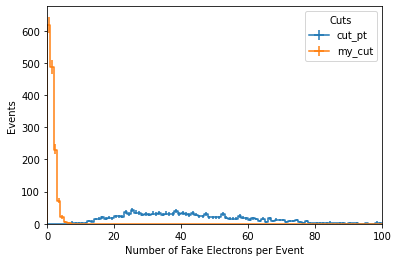

In [32]:
histo_numfakes= hist.Hist(
            "Events",
            hist.Cat("cuts", "Cuts"),
            hist.Bin("numfakes", "Number of Fake Electrons per Event", 100, 0, 100),
        )

#histo_numfakes.fill(cuts="no_cut", numfakes = np.array(numfakes(soft_eles, cuttest, matched_mask, (soft_eles.isPF == False))))
histo_numfakes.fill(cuts="cut_pt", numfakes = np.array(numfakes(soft_eles, cut_pt, matched_gen_mask, (soft_eles.isPF == False))))
histo_numfakes.fill(cuts="my_cut", numfakes = np.array(numfakes(soft_eles, cut2, matched_gen_mask, (soft_eles.isPF == False))))

print("The number of fakes per event is:")
print(sum(numfakes(soft_eles, cut2, matched_gen_mask, (soft_eles.isPF == False)))/len(numfakes(soft_eles, cut2, matched_gen_mask, (soft_eles.isPF == False))))
print("Then number of fakes per event without ID is:")
print(sum(numfakes(soft_eles, cut_pt, matched_gen_mask, (soft_eles.isPF == False)))/len(numfakes(soft_eles, cut_pt, matched_gen_mask, (soft_eles.isPF == False))))
hist.plot1d(histo_numfakes)

In [33]:
print(len(cut2(matched_eles).flatten())) #compared to 207

272


Number of gen eles with desired qualities
1440


(-0.5, 0.5)

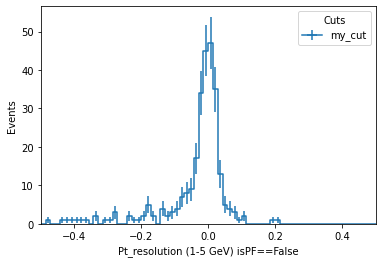

In [34]:
# pt resolution curve for 1-5 GeV
GenPart_mask = ((abs(events[MET_Jet_mask].GenPart.pdgId) == 11) 
               & (events[MET_Jet_mask].GenPart.parent.pdgId == 1000023)
               & (events[MET_Jet_mask].GenPart.status == 1) 
               & (events[MET_Jet_mask].GenPart.hasFlags(["fromHardProcess", "isFirstCopy"])))

all_gen_eles = events[MET_Jet_mask].GenPart[GenPart_mask]
print("Number of gen eles with desired qualities")
print(len(all_gen_eles.flatten()))

flat_eles = cut2(matched_eles).flatten()
pt_reso_cut2 = (flat_eles.pt - flat_eles.matched_gen.pt) / (flat_eles.matched_gen.pt)

histo_pt_reso = hist.Hist(
            "Events",
            hist.Cat("cuts", "Cuts"),
            hist.Bin("pt_reso", "Pt_resolution (1-5 GeV) isPF==False", 70, -0.5, 0.5),
        )
histo_pt_reso.fill(cuts = "my_cut", pt_reso = np.array(pt_reso_cut2))
ax_pt_reso = hist.plot1d(histo_pt_reso, overflow = "over")
ax_pt_reso.set_xlim(right=0.5, left=-0.5)

(-0.5, 0.5)

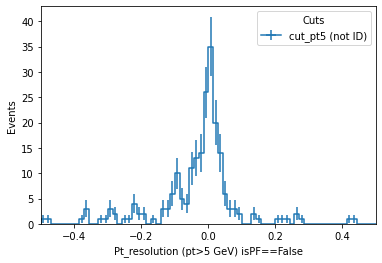

In [35]:
#pt resolution cruve for pt > 5Gev
# here I still have isPF==False
def cut_pt5(electrons):
    return electrons[
        (electrons.pt>5) 
    ]

flat_eles2 = cut_pt5(matched_eles).flatten()
pt_reso_pt5 = (flat_eles2.pt - flat_eles2.matched_gen.pt) / (flat_eles2.matched_gen.pt)

histo_pt_reso5 = hist.Hist(
            "Events",
            hist.Cat("cuts", "Cuts"),
            hist.Bin("pt_reso", "Pt_resolution (pt>5 GeV) isPF==False", 70, -0.5, 0.5),
        )
histo_pt_reso5.fill(cuts = "cut_pt5 (not ID)", pt_reso = np.array(pt_reso_pt5))
ax_pt_reso5 = hist.plot1d(histo_pt_reso5, overflow = "over")
ax_pt_reso5.set_xlim(right=0.5, left=-0.5)

(-0.5, 0.5)

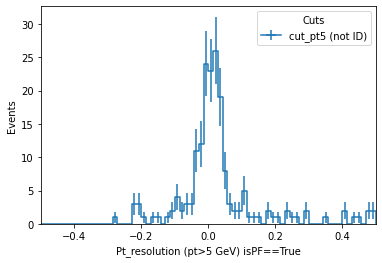

In [36]:
#pt resolution curve but with PF==True

matched_gen_mask_pt5 = ((abs(soft_eles.matched_gen.pdgId) == 11) 
               & (soft_eles.matched_gen.parent.pdgId == 1000023)
               & (soft_eles.matched_gen.status == 1) 
               & (soft_eles.matched_gen.hasFlags(["fromHardProcess", "isFirstCopy"]))
                & (soft_eles.isPF == True))


matched_eles_pt5 = soft_eles[matched_gen_mask_pt5]

flat_eles3 = cut_pt5(matched_eles_pt5).flatten()
pt_reso_PF = (flat_eles3.pt - flat_eles3.matched_gen.pt) / (flat_eles3.matched_gen.pt)

histo_pt_reso5_PF = hist.Hist(
            "Events",
            hist.Cat("cuts", "Cuts"),
            hist.Bin("pt_reso", "Pt_resolution (pt>5 GeV) isPF==True", 70, -0.5, 0.5),
        )
histo_pt_reso5_PF.fill(cuts = "cut_pt5 (not ID)", pt_reso = np.array(pt_reso_PF))
ax_pt_reso5_PF = hist.plot1d(histo_pt_reso5_PF, overflow = "over")
ax_pt_reso5_PF.set_xlim(right=0.5, left=-0.5)

In [37]:
histo_pt_reso_all = hist.Hist(
            "Events",
            hist.Cat("cuts", "Cuts"),
            hist.Bin("pt_reso", "Pt_resolution", 70, -0.5, 0.5),
        )
#histo_pt_reso_all.fill(cuts = "cut_pt>5 (no ID, not PF)", pt_reso = np.array(pt_reso_list2))
histo_pt_reso_all.fill(cuts = "my_cut", pt_reso = np.array(pt_reso_list))
histo_pt_reso_all.fill(cuts = "pt>5 (no ID, PF)", pt_reso = np.array(pt_reso_list3))
ax_pt_reso_all = hist.plot1d(histo_pt_reso_all, overflow = "all", density="True")
ax_pt_reso_all.set_xlim(right=0.5, left=-0.5)


NameError: name 'pt_reso_list' is not defined

In [38]:
#----------------------------------------------------------------------------
# pt efficiency curves
#----------------------------------------------------------------------------
histo_all = hist.Hist(
            "All",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt", 30, 1, 5),
        )

histo_all.fill(variables="denominator", soft_ele = cut_pt(matched_eles).pt.flatten())

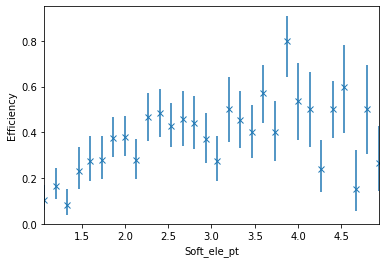

In [39]:
#total acceptance efficiency cruve
histo_all_genele = hist.Hist(
            "All",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Gen_ele_pt", 30, 1, 5),
        )
histo_eff_cut2 = hist.Hist(
            "Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt", 30, 1, 5),
        )
histo_eff_cut2.fill(variables="looseMVA", soft_ele = cut2(matched_eles).pt.flatten())
histo_all_genele.fill(variables="denominator", soft_ele = cut_pt(all_gen_eles).pt.flatten())

%matplotlib inline
hist.plotratio(num=histo_eff_cut2.integrate("variables"), denom=histo_all_genele.integrate("variables"), error_opts={"marker": "x"})

(-0.4, 0.4)

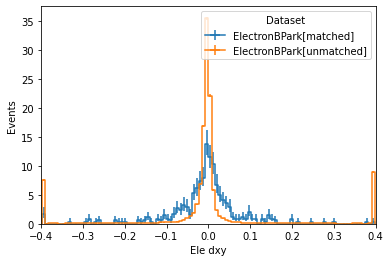

In [40]:
#guess cut: abs(0.3)
# there is indeed no underflow to the plot
# the overflow on the right is a gradually decreasin one, with no definitive spike
histo_dxy = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("dxy", "Ele dxy", 100, -0.39, 0.39),
        )
histo_dxy.fill(dataset ="ElectronBPark[matched]", dxy = cut_pt(matched_eles).dxy.flatten())
histo_dxy.fill(dataset ="ElectronBPark[unmatched]", dxy = cut_pt(unmatched_eles).dxy.flatten())
%matplotlib inline
ax_dxy = hist.plot1d(histo_dxy, density = True, overflow="all")
ax_dxy.set_xlim(right=0.4, left=-0.4)

(-1.0, 1.0)

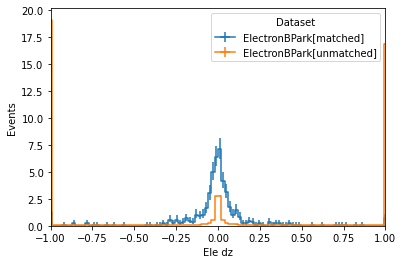

In [41]:
#guess cut: abs(0.25)
# there are supposed to be both overflow and underflow bins that are approximately symmetric
# it seems like overflow="all" is not working
histo_dz = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("dz", "Ele dz", 100, -0.99, 0.99),
        )
histo_dz.fill(dataset ="ElectronBPark[matched]", dz = cut_pt(matched_eles).dz.flatten())
histo_dz.fill(dataset ="ElectronBPark[unmatched]", dz = cut_pt(unmatched_eles).dz.flatten())
%matplotlib inline
ax_dz = hist.plot1d(histo_dz, density = True, overflow="all")
ax_dz.set_xlim(right=1, left=-1)

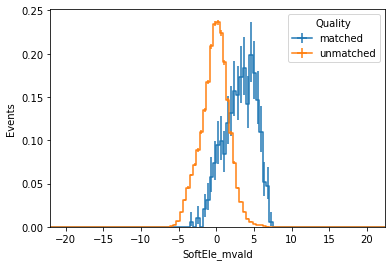

In [42]:
histo_mvaId = hist.Hist(
            "Events ",
            hist.Cat("quality", "Quality"),
            hist.Bin("soft_unmatched_ele", "SoftEle_mvaId", 100, -22, 22),
        )

histo_mvaId.fill(quality ="matched", soft_unmatched_ele=cut_pt(matched_eles).mvaId.flatten())
histo_mvaId.fill(quality ="unmatched", soft_unmatched_ele=cut_pt(unmatched_eles).mvaId.flatten())


%matplotlib inline
hist.plot1d(histo_mvaId, overflow = "over", density = True)

(0.0, 600.0)

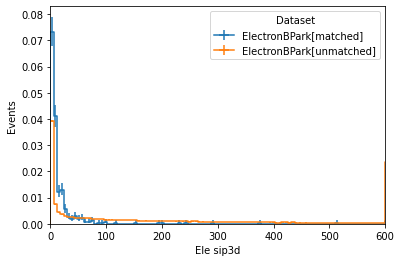

In [43]:
#guess cut: 0.2< <100
histo_sip3d = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("sip3d", "Ele sip3d", 100, 0, 600),
        )
histo_sip3d.fill(dataset ="ElectronBPark[matched]", sip3d = cut_pt(matched_eles).sip3d.flatten())
histo_sip3d.fill(dataset ="ElectronBPark[unmatched]", sip3d = cut_pt(unmatched_eles).sip3d.flatten())
%matplotlib inline
ax_sip3d = hist.plot1d(histo_sip3d, density = True, overflow="over")
ax_sip3d.set_xlim(right=600, left=0)

(-25.0, 25.0)

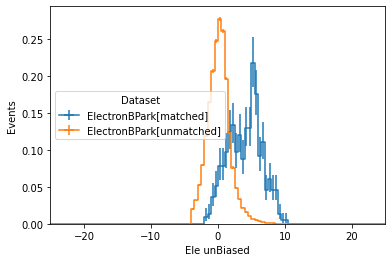

In [44]:
#guess cut: 0
histo_unBiased = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("unBiased", "Ele unBiased", 100, -25, 25),
        )
histo_unBiased.fill(dataset ="ElectronBPark[matched]", unBiased = cut_pt(matched_eles).unBiased.flatten())
histo_unBiased.fill(dataset ="ElectronBPark[unmatched]", unBiased = cut_pt(unmatched_eles).unBiased.flatten())
%matplotlib inline
ax_unBiased = hist.plot1d(histo_unBiased, density = True, overflow="over")
ax_unBiased.set_xlim(right=25, left=-25)

(-25.0, 25.0)

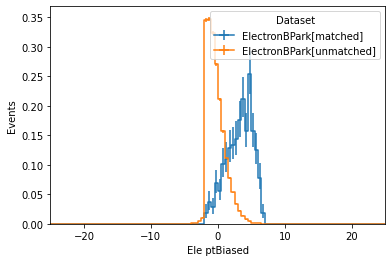

In [45]:
#guess cut:0
histo_ptBiased = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("ptBiased", "Ele ptBiased", 100, -25, 25),
        )
histo_ptBiased.fill(dataset ="ElectronBPark[matched]", ptBiased = cut_pt(matched_eles).ptBiased.flatten())
histo_ptBiased.fill(dataset ="ElectronBPark[unmatched]", ptBiased = cut_pt(unmatched_eles).ptBiased.flatten())
%matplotlib inline
ax_ptBiased = hist.plot1d(histo_ptBiased, density = True, overflow="over")
ax_ptBiased.set_xlim(right=25, left=-25)

(0.0, 2.0)

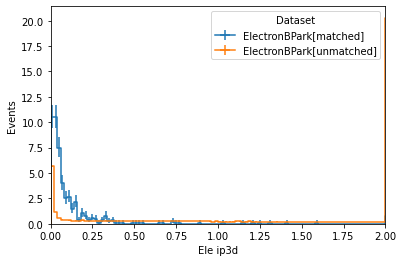

In [46]:
#guess cut: 0.5
histo_ip3d = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("ip3d", "Ele ip3d", 100, 0, 2),
        )
histo_ip3d.fill(dataset ="ElectronBPark[matched]", ip3d = cut_pt(matched_eles).ip3d.flatten())
histo_ip3d.fill(dataset ="ElectronBPark[unmatched]", ip3d = cut_pt(unmatched_eles).ip3d.flatten())
%matplotlib inline
ax_ip3d = hist.plot1d(histo_ip3d, density = True, overflow="over")
ax_ip3d.set_xlim(right=2, left=0)

(-1.9, 1.5)

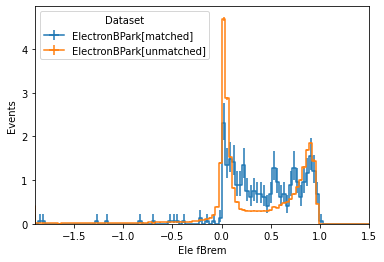

In [48]:
# guess cut > -1.9
histo_fBrem = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("dxy", "Ele fBrem", 100, -1.9, 1.5),
        )
histo_fBrem.fill(dataset ="ElectronBPark[matched]", dxy = cut_pt(matched_eles).fBrem.flatten())
histo_fBrem.fill(dataset ="ElectronBPark[unmatched]", dxy = cut_pt(unmatched_eles).fBrem.flatten())
%matplotlib inline
ax_fBrem = hist.plot1d(histo_fBrem, density = True, overflow="all")
ax_fBrem.set_xlim(right=1.5, left=-1.9)